In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from models import BasicBlock, ResNet
from vog import VoGMetric
torch.autograd.set_detect_anomaly(True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet(BasicBlock, [2, 2, 2, 2], temp=1.0, num_classes=len(classes))
metric = VoGMetric(model, device=device)


In [4]:
metric.train(trainloader, epochs=3, checkpoint_interval=1)

Epoch 1, Loss: 1.9112733784987002
Epoch 2, Loss: 1.2684615856530714
Epoch 3, Loss: 0.9629793428644842
Finished training


In [5]:
indices, metrics = metric.get_metric(testset)

print(indices.size(), metrics.size())

  5%|▍         | 15/313 [00:03<01:00,  4.93it/s]/opt/conda/lib/python3.8/site-packages/torch/autograd/__init__.py:300: UserWarning: Error detected in CudnnBatchNormBackward0. Traceback of forward call that caused the error:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.8/asyncio/base_events.py", line

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.75 GiB total capacity; 14.68 GiB already allocated; 4.44 MiB free; 14.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [8]:
from data_utils import get_subset_random_sampler

In [9]:
sampler = get_subset_random_sampler(indices, metrics, 0.5)

In [10]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, sampler=sampler)

In [11]:
s = 0
for x, y in testloader:
    s += x.size(0)
print(s)

5000


Images with the lowest VoG scores:


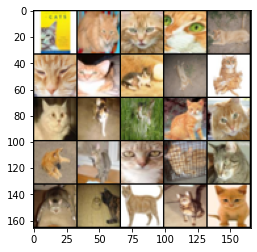

Images with the highest VoG scores:


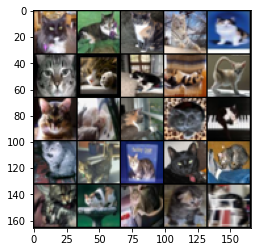

In [12]:
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def select_images_by_class(dataset, target_class):
    selected_images = []
    selected_labels = []

    for i in range(len(dataset)):
        image, label = dataset[i]
        if label == target_class:
            selected_images.append(image)
            selected_labels.append(label)

    return selected_images, selected_labels

def plot_extreme_vog_images(testset, indices, vog_scores, target_class, num_images=25):
    # Sort images by VoG scores
    sorted_indices = np.argsort(vog_scores)
    
    # Filter sorted_indices to only include indices of images that belong to the target class
    sorted_indices = [i for i in sorted_indices if testset[i][1] == target_class]
    
    # Select the top and bottom images
    lowest_vog_indices = sorted_indices[:num_images]
    highest_vog_indices = sorted_indices[-num_images:]
    
    # Create a dataset with the selected images
    lowest_vog_images = torch.stack([testset[i][0] for i in lowest_vog_indices])
    highest_vog_images = torch.stack([testset[i][0] for i in highest_vog_indices])

    # Plot the images with the lowest VoG scores
    print("Images with the lowest VoG scores:")
    imshow(vutils.make_grid(lowest_vog_images, nrow=num_images // 5, padding=1, normalize=True))

    # Plot the images with the highest VoG scores
    print("Images with the highest VoG scores:")
    imshow(vutils.make_grid(highest_vog_images, nrow=num_images // 5, padding=1, normalize=True))

# Visualize the 25 images with the lowest and highest VoG scores
plot_extreme_vog_images(testset, indices.detach().cpu(), metrics.detach().cpu(), 3)
